In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai import PowerSpectrum
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import h5py
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 27,
#           'figure.figsize': (10, 10),
         'axes.labelsize': 27,
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'figure.titlesize': 40
         }
pylab.rcParams.update(params)
plt.style.use("science")

In [3]:
model = "RIMSource128hstv3_control_002_A0_L3_FLM1.0_211108220845_lenses128hst_TNG_rau_200k_control_denoised_validated_val"
paths = glob.glob(os.path.join(os.getenv("CENSAI_PATH"), "results", model, "*.h5"))
# paths = glob.glob("/media/alexandre/Seagate/Ecole/Automne2021/Censai/results/" + model + "/*.h5")
hfs = [h5py.File(path, 'r') for path in paths]

In [75]:
# [hf.close() for hf in hfs]

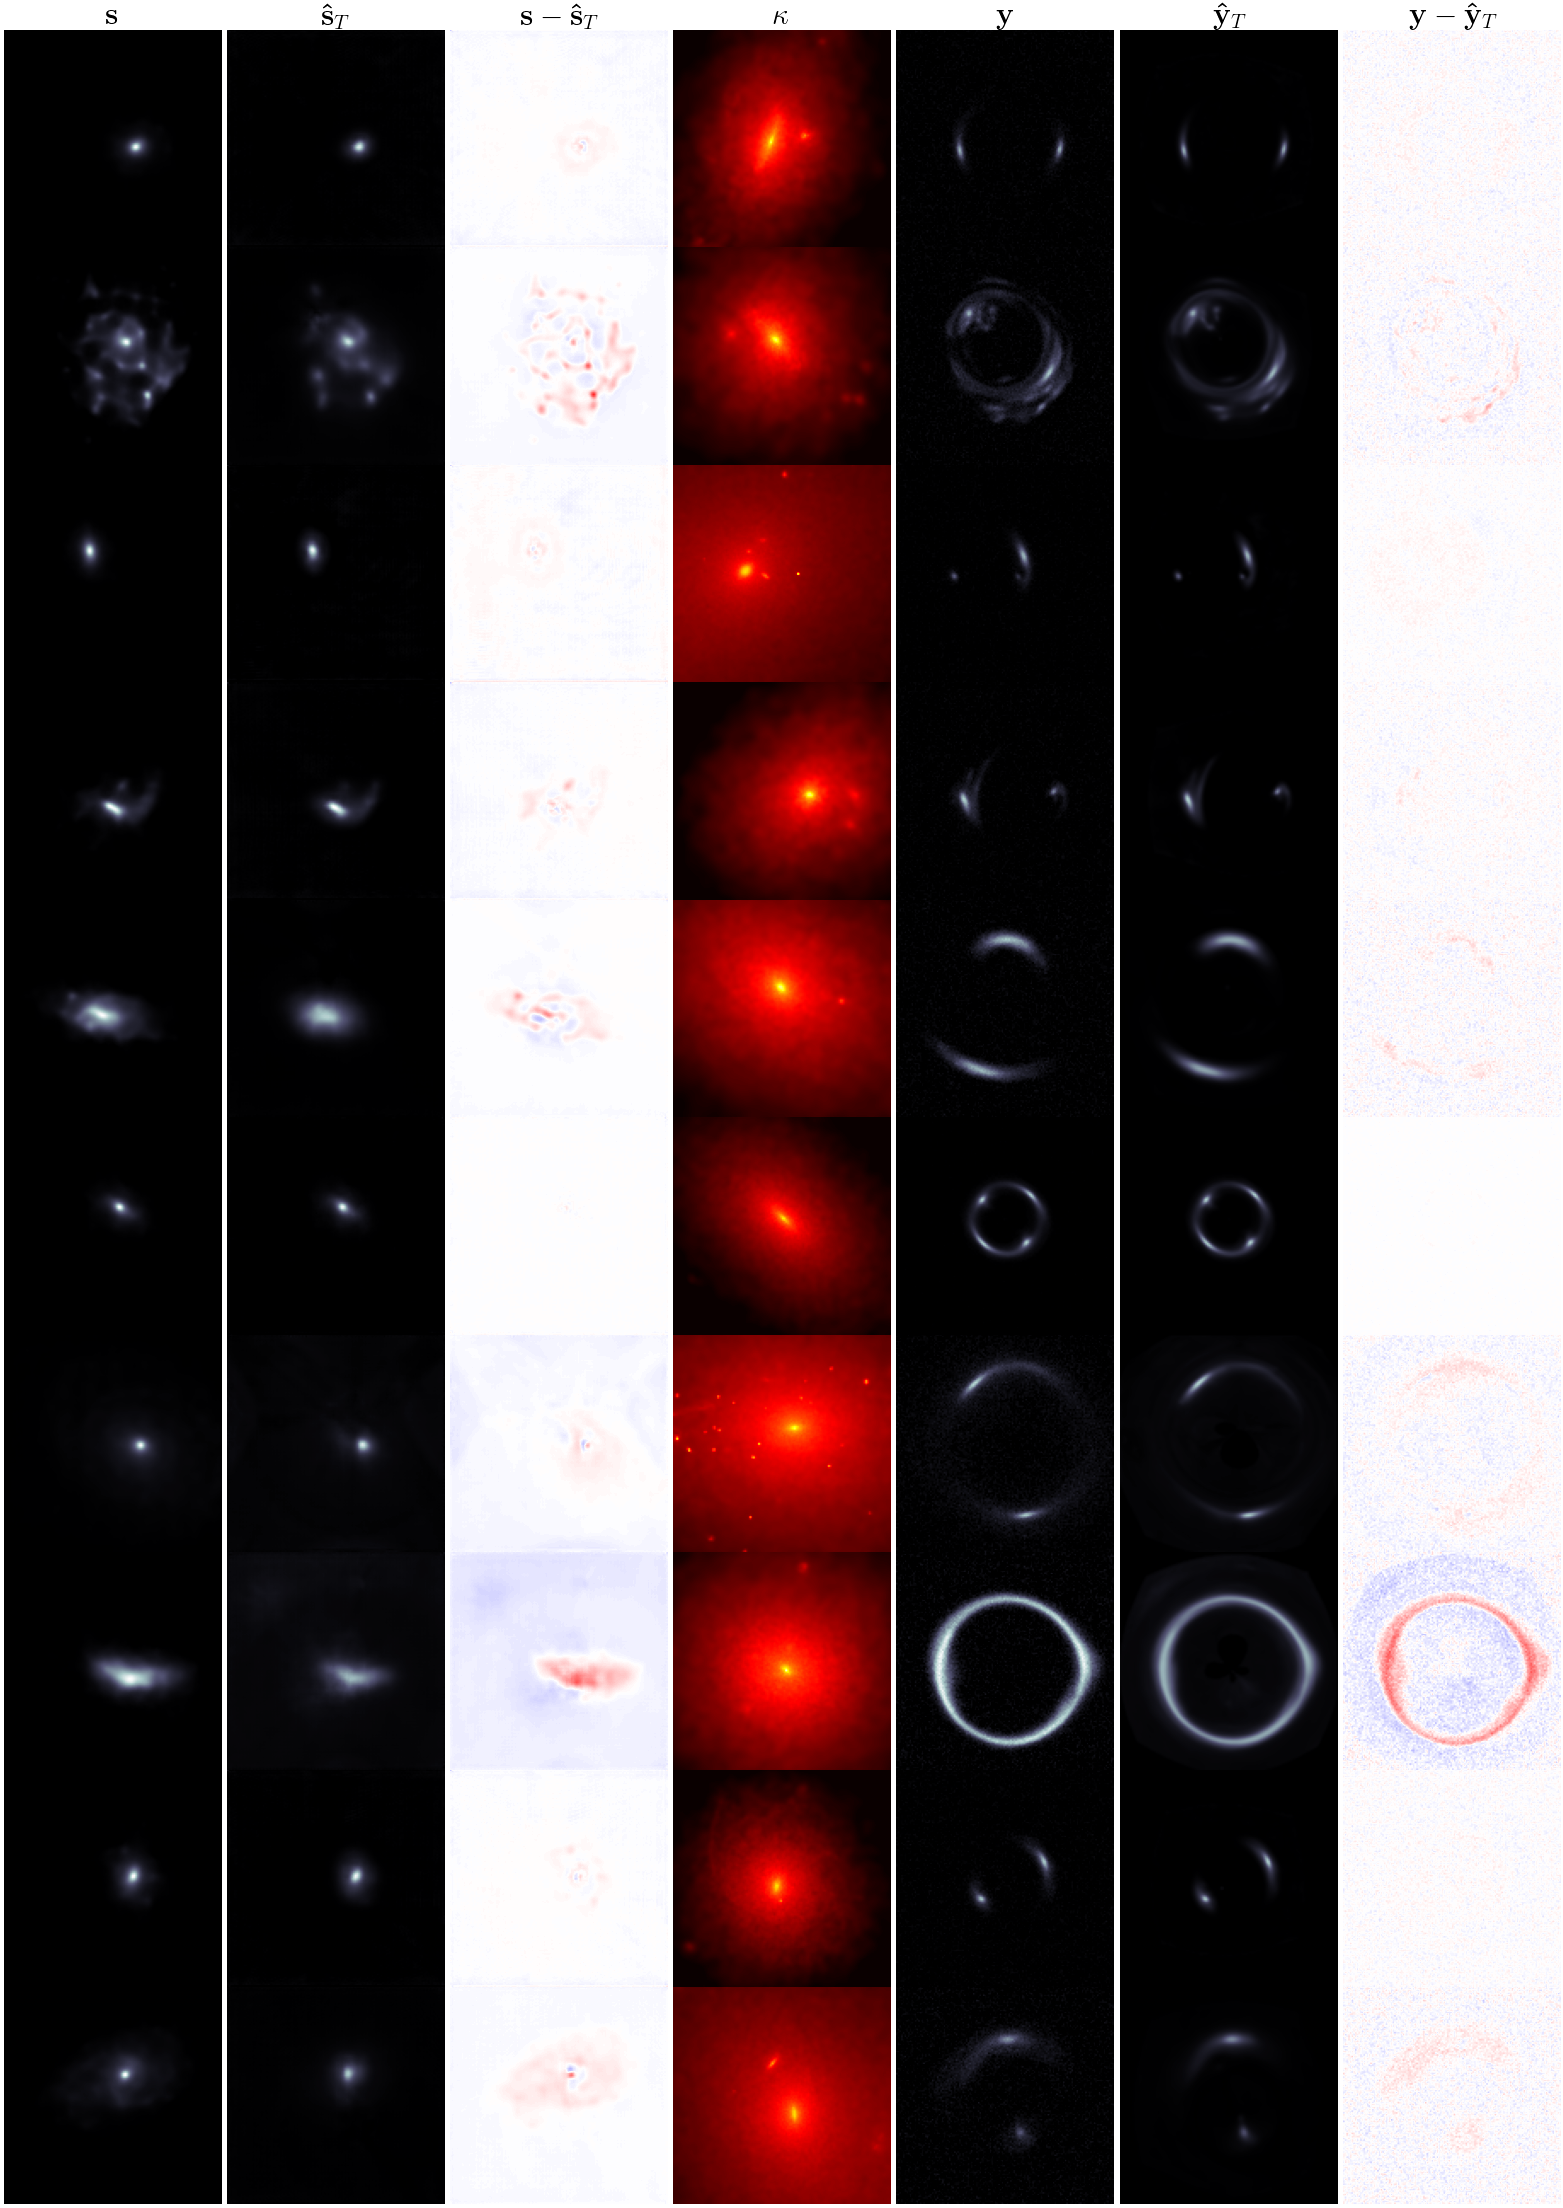

In [9]:
N = 10
start = 40
hf = hfs[1]

fig, axs = plt.subplots(N, 7, figsize=(28, 4 * N))
for i in range(N):
    k = list(hf.keys())[i + start]
    lens = np.array(hf[f"{k}/lens"]).squeeze()
    source = np.array(hf[f"{k}/source"]).squeeze()
    kappa = np.array(hf[f"{k}/kappa"]).squeeze()
    lens_pred = np.array(hf[f"{k}/lens_pred"]).squeeze()
    source_pred = np.array(hf[f"{k}/source_pred"]).squeeze()[-1]
    

    axs[i, 0].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 1].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(source - source_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    
    axs[i, 4].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 5].imshow(lens_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 6].imshow(lens - lens_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
for i in range(N):
    for j in range(7):
        axs[i, j].axis("off")


# axs[0, 0].set_title("Source")
# axs[0, 1].set_title("Source prédite")
# axs[0, 2].set_title("Différence")
# axs[0, 3].set_title("$\kappa$")
# axs[0, 4].set_title("$\hat{\kappa}_T$")
# axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
# axs[0, 6].set_title("Observation ($\mathbf{y}$)")
# axs[0, 7].set_title("Prédiction ($\mathbf{\hat{y}}_T$)")
# axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"../results/rim_pred{start:d}.png")

axs[0, 0].set_title(r"$\mathbf{s}$")
axs[0, 1].set_title(r"$\mathbf{\hat{s}}_T$")
axs[0, 2].set_title(r"$\mathbf{s} - \mathbf{\hat{s}}_T$")
axs[0, 3].set_title("$\kappa$")
axs[0, 4].set_title("$\mathbf{y}$")
axs[0, 5].set_title("$\mathbf{\hat{y}}_T$")
axs[0, 6].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
plt.subplots_adjust(wspace=0, hspace=0)


In [10]:
r_lens = []
r_source = []
i = 0
for hf in tqdm(hfs):
    for key in tqdm(list(hf.keys())):
        r_lens.append(np.array(hf[f"{key}/ps_lens"]))
        r_source.append(np.array(hf[f"{key}/ps_source"]))


100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


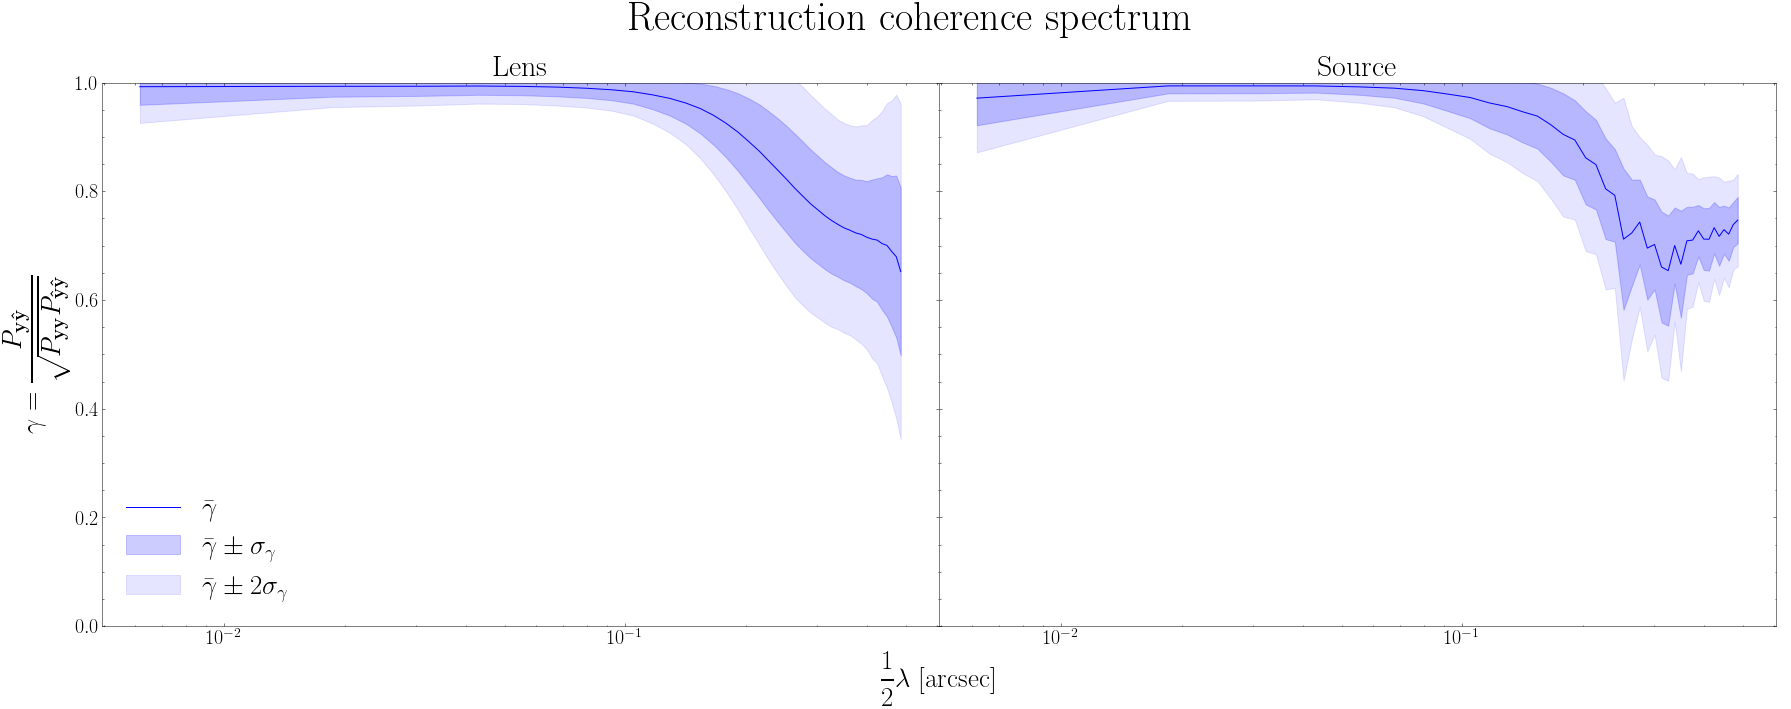

In [16]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(30, 10), sharey=True)
color = "b"

# lens
r = np.stack(r_lens, axis=0)
pixels=128
bins=r.shape[1]
fov = 7.68


r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:])/2 #/ fov * pixels
# lam = 1/f/2


ax1.plot(f, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax1.fill_between(f, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax1.fill_between(f, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
# ax1.set_xlabel(r"$\dfrac{1}{2}\lambda$ [arcsec]")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)
# plt.xlim(128, 3)
ax1.legend(loc="lower left")
ax1.set_ylabel(r"$\gamma = \dfrac{P_{\mathbf{y}\mathbf{\hat{y}}}}{\sqrt{P_{\mathbf{y}\mathbf{y}} P_{\mathbf{\hat{y}}\mathbf{\hat{y}}}}}$")
ax1.set_title("Lens")



# source
r = np.stack(r_source, axis=0)
pixels=128
bins=r.shape[1]
fov = 3


r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:])/2 #/ fov * pixels
# lam = 1/f/2


ax3.plot(f, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax3.fill_between(f, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax3.fill_between(f, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
# ax3.invert_xaxis()
ax3.set_xscale("log")
ax3.set_ylim(0, 1)
ax3.set_title("Source")
# plt.xlim(128, 3)
# ax3.legend(loc="lower left")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"$\dfrac{1}{2}\lambda$ [arcsec]")

plt.subplots_adjust(wspace=0, hspace=0);
fig.suptitle("Reconstruction coherence spectrum", y=0.99);


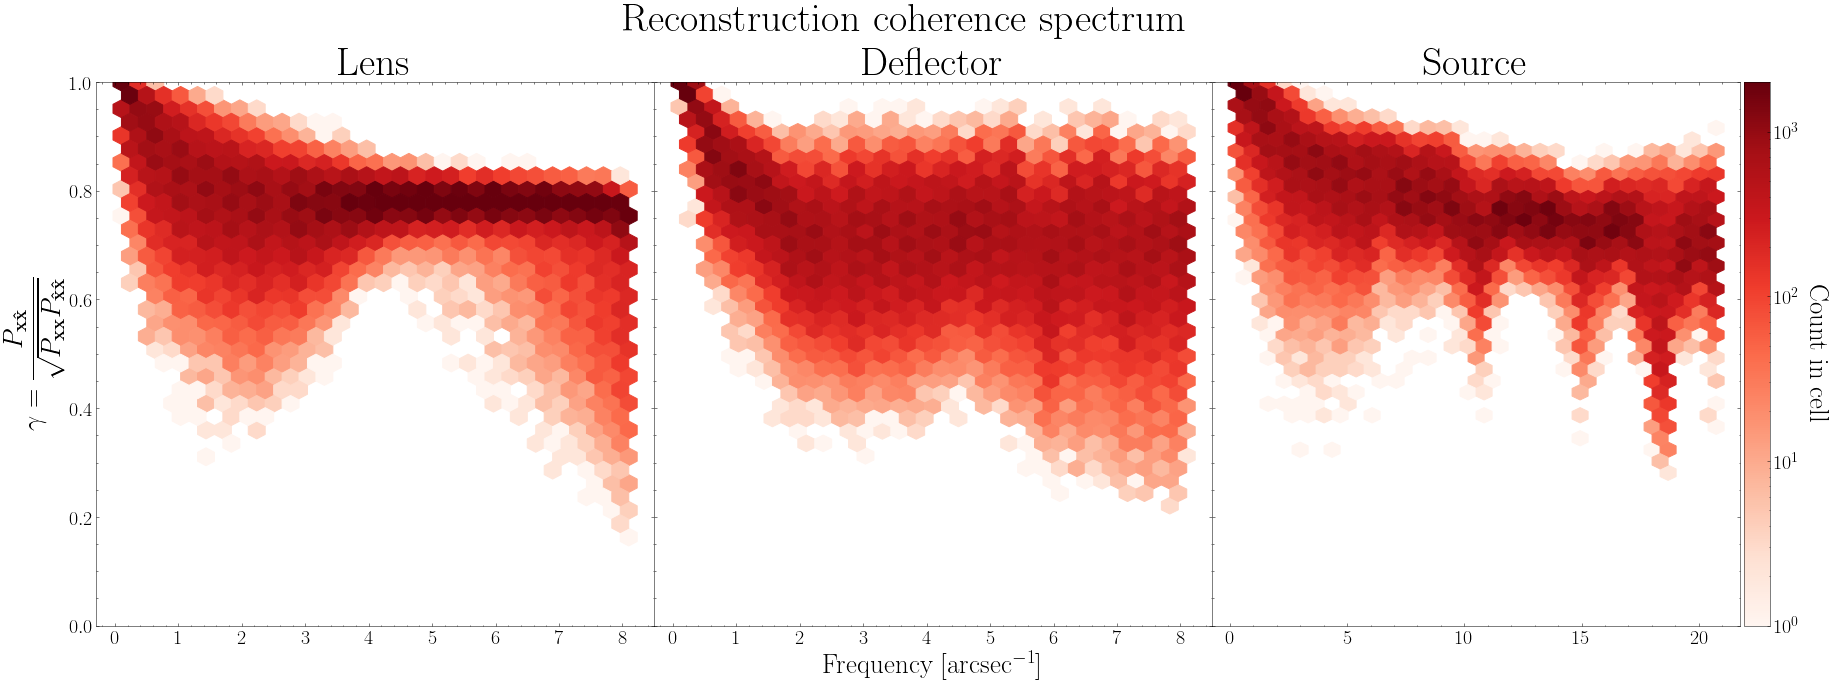

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
gridsize=30

# lens
r = np.stack(r_lens, axis=0)
pixels=128
bins=r.shape[1]
fov = 7.68

_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:])/2 / fov * pixels
f = np.tile(f, r.shape[0])

point_cloud_pred = np.stack([r.flatten(), f], axis=1)

ax1.hexbin(point_cloud_pred[:, 1], point_cloud_pred[:, 0], gridsize=gridsize, cmap='Reds', norm=LogNorm(vmin=1, vmax=2000), mincnt=1)
ax1.set_ylim(0, 1)
ax1.set_title("Lens", fontsize=40);


# kappa
r = np.stack(r_kappa, axis=0)
pixels=128
bins=r.shape[1]
fov = 7.68

_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:])/2 / fov * pixels
f = np.tile(f, r.shape[0])

point_cloud_pred = np.stack([r.flatten(), f], axis=1)

ax2.hexbin(point_cloud_pred[:, 1], point_cloud_pred[:, 0], gridsize=gridsize, cmap='Reds', norm=LogNorm(vmin=1, vmax=2000), mincnt=1)
ax2.set_ylim(0, 1)
ax2.set_title("Deflector", fontsize=40);

# source
r = np.stack(r_source, axis=0)
pixels=128
bins=r.shape[1]
fov = 3

_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:])/2 / fov * pixels
f = np.tile(f, r.shape[0])

point_cloud_pred = np.stack([r.flatten(), f], axis=1)

ax3.hexbin(point_cloud_pred[:, 1], point_cloud_pred[:, 0], gridsize=gridsize, cmap='Reds', norm=LogNorm(vmin=1, vmax=2000), mincnt=1)
ax3.set_ylim(0, 1)
ax3.set_title("Source", fontsize=40);

ax1.set_ylabel(r"$\gamma = \dfrac{P_{\mathbf{x}\mathbf{\hat{x}}}}{\sqrt{P_{\mathbf{x}\mathbf{x}} P_{\mathbf{\hat{x}}\mathbf{\hat{x}}}}}$")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ScalarMappable(cmap="Reds", norm=LogNorm(vmin=1, vmax=2000)), cax=cax)
cax.set_ylabel("Count in cell", rotation=270, labelpad=30)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Frequency [arcsec$^{-1}$]")

plt.subplots_adjust(wspace=0, hspace=0);
fig.suptitle("Reconstruction coherence spectrum", y=0.99);
plt.savefig(f"../results/{model}/rim_hexbin_coherence_spectrums.png")
